<a href="https://colab.research.google.com/github/ZenMachina16/Digital_Payments_Fraud_Detection/blob/main/fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import plotly.express as px

In [59]:
data = pd.read_csv("onlinefraud.csv", on_bad_lines='skip')

print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [61]:
print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [63]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

plot = px.pie(data, values=quantity, names = transactions, hole = 0.5, title = "Distribution of Transaction Types")
plot.show()

In [65]:
# Convert 'type' column to numerical representation using one-hot encoding
encoded_data = pd.get_dummies(data, columns=['type'])

# Include 'isFraud' in the numerical features for correlation calculation
numerical_features = encoded_data.select_dtypes(include=np.number).columns.union(['isFraud'])  # Include isFraud
encoded_data_numerical = encoded_data[numerical_features]

# Convert 'isFraud' to numerical if it's not already
# Assuming 'isFraud' is either 0/1 or "No Fraud"/"Fraud"
if encoded_data_numerical['isFraud'].dtype == object:  # Check if it's of type object (string)
    encoded_data_numerical['isFraud'] = encoded_data_numerical['isFraud'].map({'No Fraud': 0, 'Fraud': 1})

# Calculate correlation on the numerical data
correlation = encoded_data_numerical.corr()
print(correlation["isFraud"].sort_values(ascending=False))

isFraud           1.000000
amount            0.076689
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [66]:
data["type"] = data["type"].map({"CASH_OUT" : 1, "CASH_IN" : 2, "PAYMENT" : 3, "DEBIT" : 4, "TRANSFER" : 5})
data["isFraud"] = data["isFraud"].map({0 : "No Fraud", 1 : "Fraud"})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,5,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No Fraud,0


In [67]:
from sklearn.model_selection import train_test_split
x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[["isFraud"]])

In [68]:
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1, random_state = 22)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
print(model.score(xtest, ytest))

0.9997092392756443


In [69]:
features = np.array([[3, 5000, 10000, 5000]])
print(model.predict(features))

['No Fraud']


In [70]:
features = np.array([[5, 10000, 10000, 0]])
print(model.predict(features))

['Fraud']


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(xtest)

# Generate and print the confusion matrix
cm = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(ytest, y_pred))


Confusion Matrix:
[[   698     87]
 [    98 635379]]

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.88      0.89      0.88       785
    No Fraud       1.00      1.00      1.00    635477

    accuracy                           1.00    636262
   macro avg       0.94      0.94      0.94    636262
weighted avg       1.00      1.00      1.00    636262



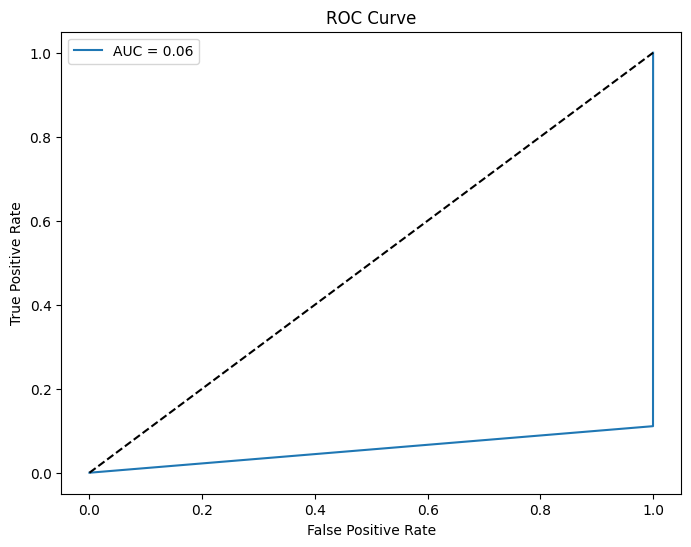

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For binary classification, you need the probability estimates
y_pred_proba = model.predict_proba(xtest)[:, 1]  # probability for the positive class (Fraud)

fpr, tpr, thresholds = roc_curve([1 if label == "Fraud" else 0 for label in ytest.flatten()], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [73]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, x, y.ravel(), cv=5, scoring='f1_macro')
print("Cross-Validation F1 Macro Scores:", cv_scores)
print("Mean F1 Macro Score:", cv_scores.mean())


Cross-Validation F1 Macro Scores: [0.9328716  0.94018321 0.93934439 0.94590989 0.94049788]
Mean F1 Macro Score: 0.9397613916662939


In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=22)
x_res, y_res = smote.fit_resample(x, y.ravel())

# Then split the resampled data
xtrain_res, xtest_res, ytrain_res, ytest_res = train_test_split(x_res, y_res, test_size=0.1, random_state=22)
model.fit(xtrain_res, ytrain_res)
print("Resampled Model Score:", model.score(xtest_res, ytest_res))


Resampled Model Score: 0.997396294381614


In [75]:
train_score = model.score(xtrain, ytrain)
test_score = model.score(xtest, ytest)
print("Training Score:", train_score)
print("Test Score:", test_score)


Training Score: 0.9996914267991721
Test Score: 0.9996275119369065
